---
title: "DSA4213 Assignment 1: Word Embeddings"
author: "Nguyen Cao Duy (A0258078R)"
date: "today"
execute:
    echo: false
    output: false
format: 
  pdf:
    toc: true
bibliography: references.bib
---

In [25]:
import os
import random
import re
import subprocess
import zipfile
from collections import Counter

import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.util import ngrams
from scipy.sparse.linalg import svds
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from wordcloud import WordCloud

if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.exists("weights"):
    os.makedirs("weights")

## 1. Data

### 1.1 Corpus Introduction
For this assignment, I use the **Corpus of Singapore English Messages (CoSEM)** as my training data [@gonzales2023corpus]. With almost 7 million words in total, this corpus contains a large collection of online text messages, reflecting contemporary Singaporean English (Singlish). By training word embedding models on this corpus, we might be able to discover interesting local colloquialisms and conversational syntax.

In [26]:
CORPUS_URL = "https://github.com/wdwgonzales/CoSEM/raw/refs/heads/main/corpus_COSEM_v5.zip"
CORPUS_PATH = "data/corpus_COSEM_v5.zip"
EXTRACTED_PATH = "data/CoSEM_v5"
if not os.path.exists(EXTRACTED_PATH):
    if not os.path.exists(CORPUS_PATH):
        print("Downloading CoSEM corpus...")
        r = requests.get(CORPUS_URL)
        with open(CORPUS_PATH, "wb") as f:
            f.write(r.content)
        print("Download complete.")
    print("Extracting corpus...")
    with zipfile.ZipFile(CORPUS_PATH, "r") as zip_ref:
        zip_ref.extractall("data")
    os.remove(CORPUS_PATH)
    print("Extraction complete.")
else:
    print("Corpus already downloaded and extracted.")

Corpus already downloaded and extracted.


### 1.2 Data Preprocessing

The raw corpus consists of 1385 individual text files, each file contains many lines of messages with private information being anonymized. For example,

```
<<COSEM:21DX12-5712-22SGCHMCK-2021>>	Tru gamers
<<COSEM:21DX12-5713-22SGCHMBL-2021>>	NM/M/CH/22 r u asleep
<<COSEM:21DX12-5714-22SGCHMBL-2021>>	{{URL}}
```

To make the corpus ready for training, a series of preprocessing steps are performed:

1.  **Consolidation**: All text files are merged into a single file, `processed_corpus.txt`.
2.  **Cleaning**: COSEM IDs, URLs, and all anonymized tags such as `<media omitted>` and `{{email}}` are all removed.
3.  **Standardization**: All text is converted to lowercase, and only alphanumeric characters and spaces are retained (words are separated by exactly a single space).

In [27]:
def clean_text(text):
    """Applies a series of cleaning steps to a line of text."""
    # Convert to lowercase
    text = text.lower()
    # Remove COSEM ID, URLs, and anonymized tags 
    text = re.sub(r"<<cosem\S*", "", text)
    text = re.sub(r"http\S*", "", text)
    text = re.sub(r"<.*omitted>", "", text) # i.e. <media omitted>, <link omitted>
    text = re.sub(r"{{.*}}", "", text) # i.e. {{email}}, {{twitter}}
    text = re.sub(r"\S*(?:/\S*){2,}", "", text) # i.e. D/F/CH/21, C/M/KOR/22
    # Keep only letters and numbers (remove all punctuation symbols)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    # Normalize whitespace (replace multiple spaces with a single one)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [28]:
TEXT_FILE_PATH = "data/processed_corpus.txt"
if not os.path.exists(TEXT_FILE_PATH):
    files_to_process = [f for f in os.listdir(EXTRACTED_PATH) if f.startswith("COSEM_v5_chunk_") and f.endswith(".txt")]
    with open(TEXT_FILE_PATH, "w") as outfile:
        for filename in tqdm(files_to_process, desc="Processing Files"):
            filepath = os.path.join(EXTRACTED_PATH, filename)
            with open(filepath, "r") as f:
                for line in f:
                    message = clean_text(line)
                    if message:
                        outfile.write(message + "\n")
    print(f"Corpus processed and saved to {TEXT_FILE_PATH}")
else:
    print("Corpus already processed.")

Corpus already processed.


After preprocessing and removing empty messages, we have a total of:

- 1,288,214 sentences
- 6,236,854 words
- 127,984 unique words


In [29]:
# Load processed sentences
all_words = []
with open(TEXT_FILE_PATH, "r") as f:
    sentences = [line.strip().split() for line in f.readlines()]
    for sentence in sentences:
        all_words.extend(sentence)
print(f"Total sentences: {len(sentences)}")
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(set(all_words))}")
print("Example sentences:")
for s in random.sample(sentences, 3):
    print(f"- {" ".join(s)}")

Total sentences: 1288214
Total words: 6236854
Unique words: 127984
Example sentences:
- when they come ill pay a homeless man to wha
- your sister btw
- nothing to do at home


### 1.3 Exploratory Data Analysis
Some visualizations are created to understand the corpus's characteristics.

#### Sentence Length Distribution
The messages are predominantly short, with most containing fewer than 10 words.

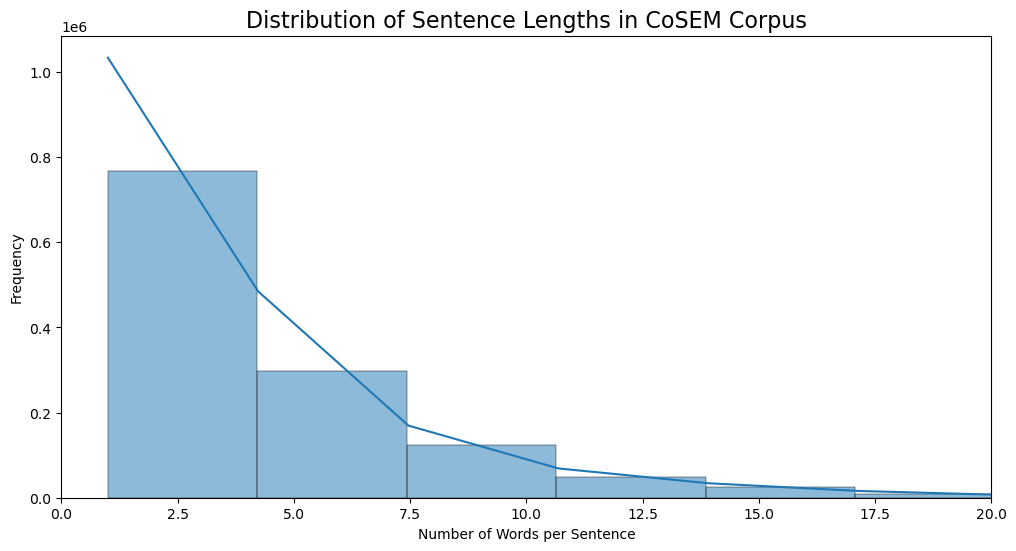

In [30]:
#| output: true
# Sentence Length Distribution
sentence_lengths = [len(sentence) for sentence in sentences]
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=200, kde=True)
plt.title("Distribution of Sentence Lengths in CoSEM Corpus", fontsize=16)
plt.xlim(0, 20)
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.savefig("sentence_length_distribution.png")
plt.show()

#### Unigram and Bigram Frequencies
The most common unigrams (single words) and bigrams (two-word phrases) highlight the conversational and localized nature of the corpus.

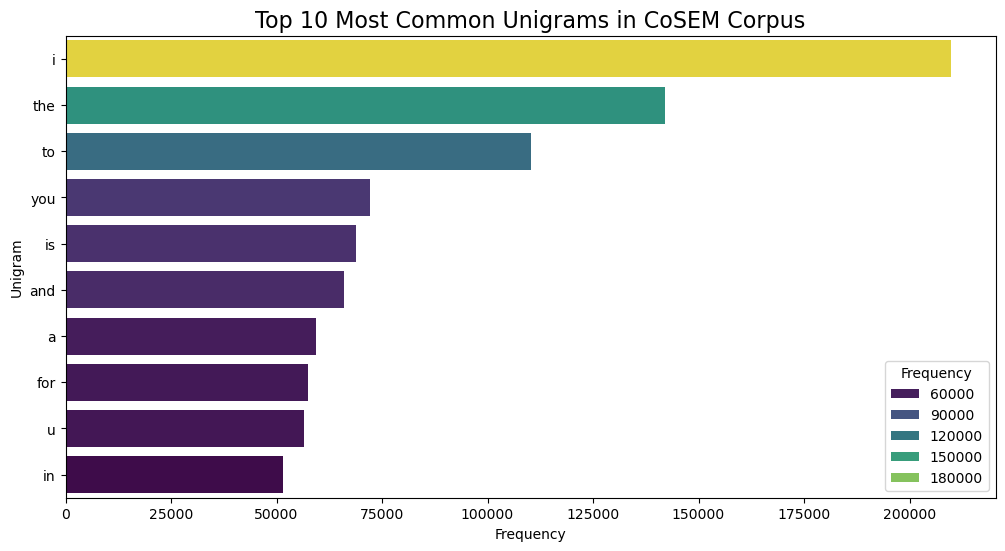

In [31]:
#| output: true
# Most Common Unigrams
unigram_counts = Counter(all_words)
most_common_unigrams = unigram_counts.most_common(10)
df_most_common = pd.DataFrame(most_common_unigrams, columns=["Unigram", "Frequency"])
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Unigram", data=df_most_common, palette="viridis", hue="Frequency")
plt.title("Top 10 Most Common Unigrams in CoSEM Corpus", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Unigram")
plt.savefig("most_common_unigrams.png")
plt.show()

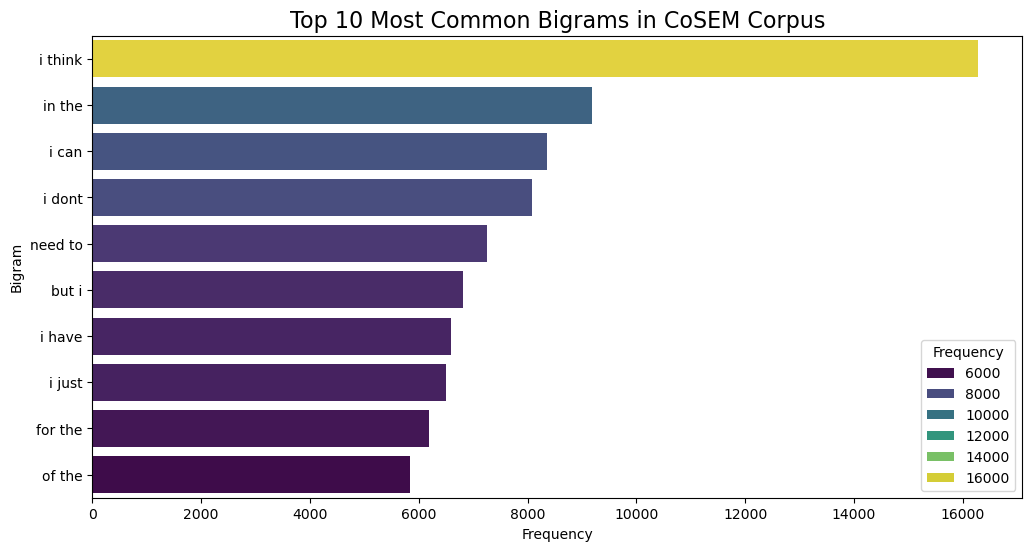

In [32]:
#| output: true
# Most Common Bigrams
bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)
most_common_bigrams = bigram_counts.most_common(10)
df_most_common = pd.DataFrame(most_common_bigrams, columns=["Bigram", "Frequency"])
df_most_common["Bigram"] = df_most_common["Bigram"].apply(lambda x: " ".join(x))
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Bigram", data=df_most_common, palette="viridis", hue="Frequency")
plt.title("Top 10 Most Common Bigrams in CoSEM Corpus", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.savefig("most_common_bigrams.png")
plt.show()

#### Word Cloud

The word cloud can also provide a visual summary of the most frequent terms in the corpus, highlighting the informal nature of online text messages in the CoSEM corpus.


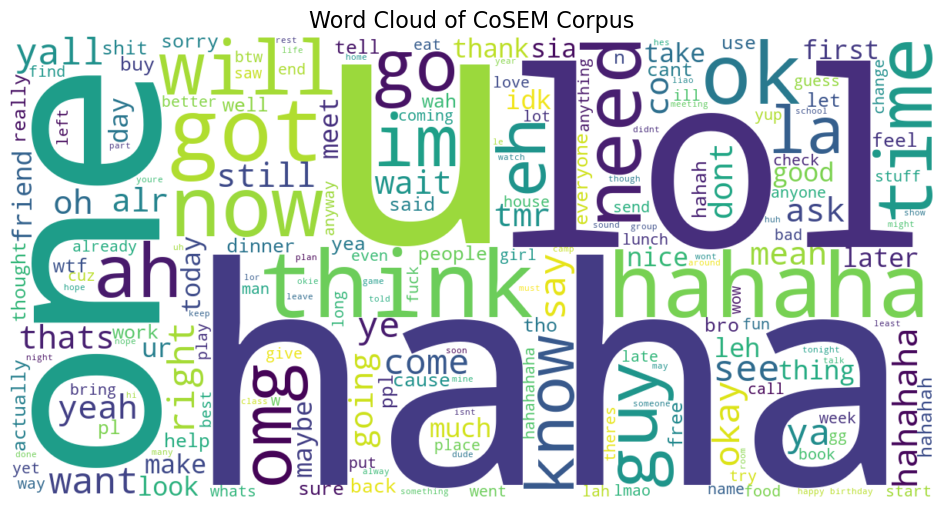

In [33]:
#| output: true
# Word Cloud
wordcloud = WordCloud(
    width=1200, 
    height=600, 
    background_color="white",
).generate(" ".join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of CoSEM Corpus", fontsize=16)
plt.savefig("word_cloud.png")
plt.show()

## 2. Models

### 2.1 Shared Hyperparameters

To ensure a fair comparison between the models later, the following core hyperparameters are kept consistent across all models:

| Parameter              | Skip-gram | SPPMI-SVD | GloVe | Description                               |
| ---------------------- | --------- | --------- | ----- | ----------------------------------------- |
| **Vector Size** | 50 | 50 | 50 | Dimensionality of each word embedding |
| **Window Size** | 5 | 5 | 5 | Context window size |
| **Minimum Vocabulary Count** | 10 | 10 | 10 | Minimum word frequency to be included in vocabulary |
| **Maximum Iterations** | 15 | - | 15 | Maximum training iterations |
| **Negative Samples** | 5 | 5 | - | Number of negative samples for training |

**Note**: With the minimum word frequency set to 10, the final vocabulary size for all models is reduced to 19,121 words.

In [34]:
# Shared Hyperparameters
VECTOR_SIZE = 50     # Dimensionality of word vectors
VOCAB_MIN_COUNT = 10 # Minimum word frequency to be included in the vocabulary
WINDOW_SIZE = 5      # Context window size
MAX_ITER = 15        # Maximum training iterations (used in Skip-gram and GloVe)
K_NEGATIVE = 5       # Number of negative samples for Negative Sampling (used in Skip-gram and SPPMI-SVD)
NUM_THREADS = 4      # Number of training threads (used in Skip-gram and GloVe)

### 2.2 Word2Vec (Skip-gram)

The Skip-gram model is a predictive model that learns word embeddings by trying to predict the context words surrounding a given center word using a neural network [@mikolov2013efficient].

The model is trained using the `gensim` library [@radim2011gensim], with negative sampling for efficient training [@mikolov2013distributed]. Other than the shared hyperparameters mentioned earlier, the following default hyperparameters were used for the Skip-gram model:

| Parameter       | Value  | Description                                                           |
| --------------- | ------ | --------------------------------------------------------------------- |
| **ns_exponent** | 0.75   | Exponent for negative sampling distribution                           |
| **alpha**       | 0.025  | Initial learning rate                                                 |
| **min_alpha**   | 0.0001 | Minimum learning rate as learning rate linearly drops during training |


In [35]:
# Adapted from gensim https://radimrehurek.com/gensim/models/word2vec.html
SKIPGRAM_PATH = "weights/skipgram.model"
if not os.path.exists(SKIPGRAM_PATH):
    print(f"Skip-gram vectors not found at {SKIPGRAM_PATH}. Training...")
    skipgram_model = Word2Vec(sentences, vector_size=VECTOR_SIZE, window=WINDOW_SIZE, min_count=VOCAB_MIN_COUNT, sg=1, hs=0, negative=K_NEGATIVE, ns_exponent=0.75, epochs=MAX_ITER, workers=NUM_THREADS)
    skipgram_model.save(SKIPGRAM_PATH)
    print(f"Skip-gram training complete. Vectors saved to {SKIPGRAM_PATH}.")
else:
    print("Skip-gram model already exists. Loading from disk.")
    skipgram_model = Word2Vec.load(SKIPGRAM_PATH)
print(f"Skip-gram model vocabulary size: {len(skipgram_model.wv.key_to_index)}")

Skip-gram model already exists. Loading from disk.
Skip-gram model vocabulary size: 19121


### 2.3 SPPMI-SVD

This is a count-based method that operates on a co-occurrence matrix. It can be shown that training Word2Vec Skip-gram model with $k$ negative samples is equivalent to factorizing the shifted point-wise mutual information matrix [@levy2014neural]. The matrix $M$ can be defined as:

$$M_{ij} = \mathbf{w}_i \cdot \mathbf{c}_j = PMI(i, j) - \log k = \log\left(\frac{P(i, j)}{P(i)P(j)}\right) - \log k$$

<!-- We can then factorize this matrix using **Singular Value Decomposition (SVD)** into $M = U \Sigma V^T = U \sqrt \Sigma \sqrt \Sigma V^T$ -->

With **Shifted Positive Pointwise Mutual Information (SPPMI)**, we actually modify $M_{ij}=\max(0, PMI(i, j) - \log k)$ to ensure non-negativity. Then **Singular Value Decomposition (SVD)** is used to factorize $M = U \Sigma V^T = (U \Sigma^{1/2})(\Sigma^{1/2} V^T)$. $(U \Sigma^{1/2})$ is used to obtain the word embeddings where we only use the top singular values and corresponding singular vectors from $U$ and $\Sigma^{1/2}$ (50 in our case).

This algorithm is implemented using standard Python and `scipy` for efficient SVD computation.

In [36]:
# Adapted from DSA4213 Lecture Slides
SPPMI_SVD_PATH = "weights/sppmi_svd.model"
CO_OCCURRENCE_MATRIX = "weights/co_occurrence_matrix.npy"
SPPMI_MATRIX = "weights/sppmi_matrix.npy"
if not os.path.exists(SPPMI_SVD_PATH):
    print(f"SPPMI-SVD vectors not found at {SPPMI_SVD_PATH}. Training...")
    print("\n--- 1. Building Vocabulary ---")
    word_counts = Counter(all_words)
    vocab = {word: count for word, count in word_counts.items() if count >= VOCAB_MIN_COUNT} 
    vocab = {word: idx for idx, word in enumerate(vocab.keys())}
    vocab_size = len(vocab)
    print(f"SPPMI-SVD vocabulary size: {vocab_size}")
    print("\n--- 2. Building Co-occurrence Matrix ---")
    if not os.path.exists(CO_OCCURRENCE_MATRIX):
        co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            sentence_length = len(sentence)
            for idx, word in enumerate(sentence):
                if word in vocab:
                    start = max(0, idx - WINDOW_SIZE)
                    end = min(sentence_length, idx + WINDOW_SIZE + 1)
                    for context_idx in range(start, end):
                        if idx != context_idx and sentence[context_idx] in vocab:
                            co_matrix[vocab[word], vocab[sentence[context_idx]]] += 1
        np.save(CO_OCCURRENCE_MATRIX, co_matrix)
    else:
        co_matrix = np.load(CO_OCCURRENCE_MATRIX)
    print("Co-occurrence matrix built.")
    print("\n--- 3. Computing SPPMI Matrix ---")
    if not os.path.exists(SPPMI_MATRIX):
        co_occurrence_sum = np.sum(co_matrix)
        p_word = np.sum(co_matrix, axis=1) / co_occurrence_sum
        sppmi_matrix = np.zeros_like(co_matrix)
        for i in tqdm(range(vocab_size), desc="Computing SPPMI"):
            for j in range(vocab_size):
                if co_matrix[i, j] > 0:
                    pmi = np.log((co_matrix[i, j] / co_occurrence_sum) / (p_word[i] * p_word[j]))
                    sppmi_matrix[i, j] = max(pmi - np.log(K_NEGATIVE), 0) # Shifted Positive PMI
        np.save(SPPMI_MATRIX, sppmi_matrix)
    else:
        sppmi_matrix = np.load(SPPMI_MATRIX)
    print("SPPMI matrix computed.")
    print("\n--- 4. Performing SVD ---")
    U, Sigma, Vt = svds(sppmi_matrix, k=VECTOR_SIZE) # Faster than np.linalg.svd on sparse matrices
    print("SVD complete.")
    print("\n--- 5. Saving SPPMI Vectors in Word2Vec Format ---")
    Sigma_k = np.diag(Sigma)
    Sigma_k_sqrt = np.sqrt(Sigma_k)
    sppmi_embeddings = U @ Sigma_k_sqrt
    with open(SPPMI_SVD_PATH, "w") as f:
        f.write(f"{vocab_size} {VECTOR_SIZE}\n")
        for word, idx in vocab.items():
            vector_str = " ".join(map(str, sppmi_embeddings[idx]))
            f.write(f"{word} {vector_str}\n")
else:
    print("SPPMI-SVD model already exists. Loading from disk.")
sppmi_svd_model = KeyedVectors.load_word2vec_format(SPPMI_SVD_PATH)

SPPMI-SVD model already exists. Loading from disk.


### 2.4 GloVe

GloVe (Global Vectors) is another count-based method that operates on a co-occurrence matrix [@pennington2014glove]. Its objective function is to learn vectors such that their dot product equals the logarithm of their co-occurrence probability $w_i \cdot w_j = \log P(w_i | w_j)$ by minimizing a weighted least squares objective that captures the ratios of co-occurrence probabilities $J = \sum_{i,j} f(X_{ij}) \cdot (\mathbf{w}_i^T \tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij})^2$ where $X_{ij}$ is the co-occurrence count, and $f(x) = (x / c)^\alpha$ if $x < c$ and $1$ otherwise.

This model is trained using the official GloVe [implementation](https://github.com/stanfordnlp/GloVe) from Stanford NLP Group (in C programming language) with the hyperparameters $c = 10$, and $\alpha = 0.75$.

In [37]:
# Follow installation instructions from https://github.com/stanfordnlp/GloVe
!git clone https://github.com/stanfordnlp/GloVe.git
!cd GloVe && make

fatal: destination path 'GloVe' already exists and is not an empty directory.
mkdir -p build


In [38]:
# Adapted from https://github.com/stanfordnlp/GloVe/blob/master/demo.sh
CORPUS = "data/processed_corpus.txt"
VOCAB_FILE = "weights/glove_vocab.txt"
COOCCURRENCE_FILE = "weights/glove_cooccurrence.bin"
COOCCURRENCE_SHUF_FILE = "weights/glove_cooccurrence.shuf.bin"
BUILDDIR = "GloVe/build"
SAVE_FILE = "weights/glove_vectors"
VERBOSE = "2"
MEMORY = "4.0"
BINARY = "2"
X_MAX = "10"
FINAL_SAVE_FILE = f"{SAVE_FILE}.txt"

if not os.path.exists(FINAL_SAVE_FILE):
    print(f"GloVe vectors not found at {FINAL_SAVE_FILE}. Training...")

    print("\n--- 1. Building Vocabulary ---")
    vocab_command = [f"{BUILDDIR}/vocab_count", "-min-count", str(VOCAB_MIN_COUNT), "-verbose", VERBOSE]
    with open(CORPUS, "r") as f_corpus, open(VOCAB_FILE, "w") as f_vocab:
        subprocess.run(vocab_command, stdin=f_corpus, stdout=f_vocab)
    print(f"Vocabulary file created at {VOCAB_FILE}")
    print("\n--- 2. Building Co-occurrence Matrix ---")
    cooccur_command = [f"{BUILDDIR}/cooccur", "-memory", MEMORY, "-vocab-file", VOCAB_FILE, "-verbose", VERBOSE, "-window-size", str(WINDOW_SIZE)]
    with open(CORPUS, "r") as f_corpus, open(COOCCURRENCE_FILE, "wb") as f_cooccur:
        process = subprocess.run(cooccur_command, stdin=f_corpus, stdout=f_cooccur)
    print(f"Co-occurrence file created at {COOCCURRENCE_FILE}")
    print("\n--- 3. Shuffling Co-occurrence Data ---")
    shuffle_command = [f"{BUILDDIR}/shuffle", "-memory", MEMORY, "-verbose", VERBOSE]
    with open(COOCCURRENCE_FILE, "rb") as f_cooccur, open(COOCCURRENCE_SHUF_FILE, "wb") as f_shuf:
        process = subprocess.run(shuffle_command, stdin=f_cooccur, stdout=f_shuf)
    print(f"Shuffled co-occurrence file created at {COOCCURRENCE_SHUF_FILE}")
    print("\n--- 4. Training GloVe Model ---")
    glove_command = [f"{BUILDDIR}/glove", "-save-file", SAVE_FILE, "-threads", str(NUM_THREADS), "-input-file", COOCCURRENCE_SHUF_FILE, "-x-max", X_MAX, "-iter", str(MAX_ITER), "-vector-size", str(VECTOR_SIZE), "-binary", BINARY, "-vocab-file", VOCAB_FILE, "-verbose", VERBOSE]
    process = subprocess.run(glove_command)
    print(f"GloVe training complete. Vectors saved to {SAVE_FILE}.txt")
else:
    print(f"GloVe vectors already exist at {FINAL_SAVE_FILE}. Skipping training.")

# Load the GloVe vectors into gensim
GLOVE_PATH = f"weights/glove.model"
if not os.path.exists(GLOVE_PATH):
    print("Converting GloVe format to Word2Vec format...")
    glove2word2vec(FINAL_SAVE_FILE, GLOVE_PATH)
else:
    print("GloVe Word2Vec format already exists. Loading from disk.")
glove_model = KeyedVectors.load_word2vec_format(GLOVE_PATH)

GloVe vectors already exist at weights/glove_vectors.txt. Skipping training.
GloVe Word2Vec format already exists. Loading from disk.


## 3. Evaluation

### 3.1 Nearest Neighbors Analysis

In this section, we will present the top 5 nearest neighbors for a curated list of common Singlish words for each of the three models. The meaning of each Singlish word will also be provided for better understanding, with references from [@SinglishDict_2024].

In [39]:
models = [(skipgram_model.wv, "Skip-gram"), (sppmi_svd_model, "SPPMI-SVD"), (glove_model, "GloVe")]

#### 3.1.1 kiasu

> scared of losing out and being uncompetitive with others; selfish; overly-competitive to the point of stepping over others

None of the models display the closest synonyms to `kiasu` as `selfish` or `competitive`, but their closest words do show a negative connotation.

In [40]:
#| output: true
word = "kiasu"
row_data = {}
for model, model_name in models:
    entries = []
    if word in model:
        similar_words = model.most_similar(word, topn=5)
        for rank, (similar_word, _) in enumerate(similar_words, 1):
            entries.append(similar_word)
    else:
        entries = ["Not in vocabulary"] * 5
    row_data[model_name] = entries
df = pd.DataFrame.from_dict(row_data, orient="index", columns=[f"Rank {i}" for i in range(1, 6)])
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Skip-gram,frustrating,agitated,enthu,misleading,distracting
SPPMI-SVD,simp,irritating,racist,anal,unlucky
GloVe,opponents,pressing,gathered,faulty,mutually


#### 3.1.2 chope

> to reserve; to 'call dibs' on, especially a table or seat. It is usually customary accompany this by leaving a small personal object behind as a marker of reservation, such as a packet of tissue paper.

Skip-gram display the closest synonym to `chope` as `reserve` (although not ranked 1), while SPPMI-SVD and GloVe display objects that are usually associated with the act of `chope`ing, such as `seat`.

In [41]:
#| output: true
word = "chope"
row_data = {}
for model, model_name in models:
    entries = []
    if word in model:
        similar_words = model.most_similar(word, topn=5)
        for rank, (similar_word, _) in enumerate(similar_words, 1):
            entries.append(similar_word)
    else:
        entries = ["Not in vocabulary"] * 5
    row_data[model_name] = entries
df = pd.DataFrame.from_dict(row_data, orient="index", columns=[f"Rank {i}" for i in range(1, 6)])
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Skip-gram,kope,reserve,w8,collate,kup
SPPMI-SVD,seated,seat,studio,clubroom,aircon
GloVe,seat,search,review,compile,google


#### 3.1.3 paiseh

> embarrassed; shy; ashamed; sorry

All models recognize the emotional weight of `paiseh`, and display similar words with apologetic connotations.

In [42]:
#| output: true
word = "paiseh"
row_data = {}
for model, model_name in models:
    entries = []
    if word in model:
        similar_words = model.most_similar(word, topn=5)
        for rank, (similar_word, _) in enumerate(similar_words, 1):
            entries.append(similar_word)
    else:
        entries = ["Not in vocabulary"] * 5
    row_data[model_name] = entries
df = pd.DataFrame.from_dict(row_data, orient="index", columns=[f"Rank {i}" for i in range(1, 6)])
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Skip-gram,sorz,sorry,sry,soz,psps
SPPMI-SVD,soz,sorz,ltr,dunnid,oops
GloVe,lambat,sorz,soz,sry,opps


#### 3.1.4 sian

> boring; tiresome; insipid

All models displays the closest synonyms to `sian` as `shag` (which is another local slang term for feeling bored or tired). Other related words with a similar sentiment (tiring) are also shown.

In [43]:
#| output: true
word = "sian"
row_data = {}
for model, model_name in models:
    entries = []
    if word in model:
        similar_words = model.most_similar(word, topn=5)
        for rank, (similar_word, _) in enumerate(similar_words, 1):
            entries.append(similar_word)
    else:
        entries = ["Not in vocabulary"] * 5
    row_data[model_name] = entries
df = pd.DataFrame.from_dict(row_data, orient="index", columns=[f"Rank {i}" for i in range(1, 6)])
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Skip-gram,sianz,shag,siann,sadz,yalo
SPPMI-SVD,dam,shag,scary,damn,wah
GloVe,shag,sia,damn,wah,scared


#### 3.1.5 dabao

> (of food) to take-away; to order to go

Skip-gram and GloVe display the closest synonym to `dabao` as `dapao` (which is a variation in spelling). Similar to the example of `chope` above, SPPMI-SVD displays words that are usually associated with the act of `dabao`ing instead of synonyms.


In [44]:
#| output: true
word = "dabao"
row_data = {}
for model, model_name in models:
    entries = []
    if word in model:
        similar_words = model.most_similar(word, topn=5)
        for rank, (similar_word, _) in enumerate(similar_words, 1):
            entries.append(similar_word)
    else:
        entries = ["Not in vocabulary"] * 5
    row_data[model_name] = entries
df = pd.DataFrame.from_dict(row_data, orient="index", columns=[f"Rank {i}" for i in range(1, 6)])
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Skip-gram,dapao,tabao,tapao,subway,cook
SPPMI-SVD,eating,hwangs,eat,kopitiam,banmian
GloVe,dapao,groceries,buy,prepare,fetch


### 3.2 Word Analogy Analysis

This extends the previous section by experimenting with word analogies using vector operations. We will find the most similar words `d` for each analogy `a - b = c - d`. 

Although there are many possible answers besides the `Expected` ones and the sample set is small, SPPMI-SVD gives pretty good results compared to the other models, although none of them gives satisfactory answers for all 5 rows.

In [45]:
#| output: true
analogies = [
    ("dad", "mom", "male", "female"), # gender
    ("coffee", "tea", "kopi", "teh"), # food
    ("singapore", "malaysia", "sgd", "ringgit"), # currency
    ("student", "students", "teacher", "teachers"), # pluralization
    ("low", "lower", "high", "higher"), # comparison
]
def get_analogy_prediction(model, a, b, c):
    """Performs the analogy task and returns the top predicted word."""
    if all(word in model for word in [a, b, c]):
        result = model.most_similar(positive=[c, b], negative=[a], topn=1)
        return result[0][0]
    return "NA"
results = []
for a, b, c, expected in analogies:
    sg_pred = get_analogy_prediction(skipgram_model.wv, a, b, c)
    sppmi_pred = get_analogy_prediction(sppmi_svd_model, a, b, c)
    glove_pred = get_analogy_prediction(glove_model, a, b, c)
    results.append({
        "Analogy Task": f"`{c}` + `{b}` - `{a}`",
        "Expected": expected,
        "Skip-gram": sg_pred,
        "SPPMI-SVD": sppmi_pred,
        "GloVe": glove_pred
    })
df = pd.DataFrame(results)
display(df)

/Users/ncduy/mambaforge/envs/dsa4213-assignment-1/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,Analogy Task,Expected,Skip-gram,SPPMI-SVD,GloVe
0,`male` + `mom` - `dad`,female,dictator,female,models
1,`kopi` + `tea` - `coffee`,teh,halia,oolong,fee
2,`sgd` + `malaysia` - `singapore`,ringgit,13k,ringgit,1520
3,`teacher` + `students` - `student`,teachers,tutor,math,senior
4,`high` + `lower` - `low`,higher,upper,higher,higher


### 3.3 Visualization of Embedding Space

In this section, we compare t-SNE visualization of the embedding space for the following Singaporean-themed word clusters between different models:

- Common Singlish particles: `lah`, `lor`, `leh`, `meh`, `liao`, `sia`, `hor`, `mah`, `bah`, `wor`
- Common Singaporean foods: `nasi`, `roti`, `prata`, `laksa`, `durian`, `satay`, `rojak`, `mee`, `kaya`, `curry`
- Common Singaporean places: `orchard`, `marina`, `sentosa`, `bugis`, `chinatown`, `yishun`, `changi`, `jurong`, `harbourfront`, `punggol`

From the visualization, all models can separate the different clusters reasonably well, especially Skip-gram where the clusters are very localized and exhibit clear boundaries from one another.

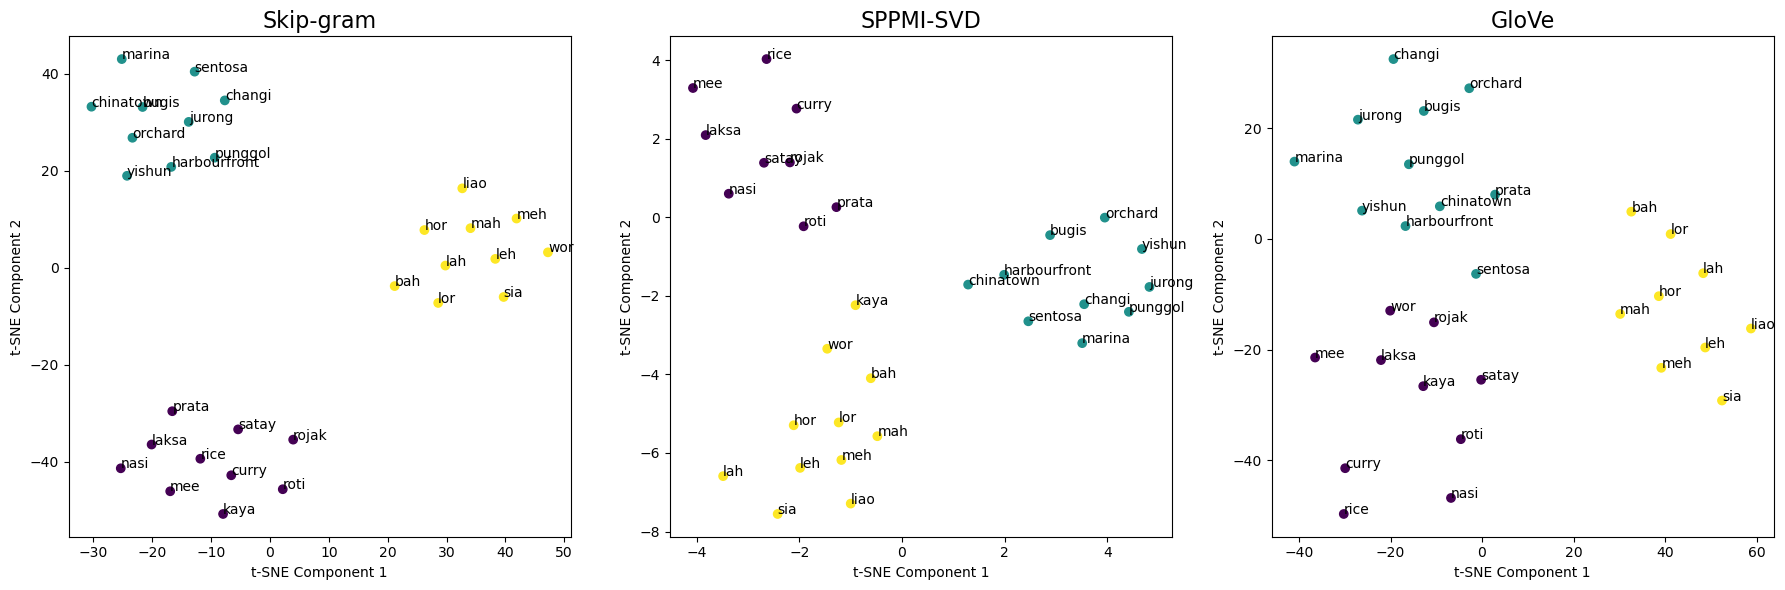

In [46]:
#| output: true
words = [
    "lah", "lor", "leh", "meh", "liao", "sia", "hor", "mah", "bah", "wor", # Common Singlish particles
    "nasi", "roti", "prata", "laksa", "rice", "satay", "rojak", "mee", "kaya", "curry", # Common food in Singapore
    "orchard", "marina", "sentosa", "bugis", "chinatown", "yishun", "changi", "jurong", "harbourfront", "punggol" # Common places in Singapore
]
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 6))
for ax, (model, model_name) in zip(axes, models):
    embeddings = model[words]
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_embeddings = tsne.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    scatter = ax.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        marker='o',
        c=cluster_labels,
        cmap='viridis'
    )
    for i, word in enumerate(words):
        ax.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)
    ax.set_title(f"{model_name}", fontsize=16)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

### 3.4 Benchmarking

This section provides a quantitative intrinsic evaluation of all models on WordSim-353, a widely used benchmark for assessing word embeddings [@finkelstein2001placing]. We can compare the Spearman correlation between the cosine similarity of the model embeddings and the human-annotated similarity scores between our 3 models, as well as pretrained word embeddings downloaded from `gensim` library.

From the benchmarking results, it is not surprising that our models do not perform as well as the pretrained embeddings (especially those with embedding size 300), given the limited training data (millions of tokens vs. billions for pretrained models) and the nature of the CoSEM corpus being informal text messages and Singaporean English-specific. Many of the words in the test set are not in our vocabulary where our models only cover 270/353 pairs.

Among our models, SPPMI-SVD performed the best with a Spearman correlation of 0.3874, and Skip-gram followed closely behind. Surprisingly, GloVe showed much lower performance at only 0.1952.

In [ ]:
WORDSIM_353_URL = 'https://gabrilovich.com/resources/data/wordsim353/wordsim353.zip'
WORDSIM_353_PATH = 'data/wordsim353.zip'
WORDSIM_353_FILE = 'data/wordsim353.csv'
if not os.path.exists(WORDSIM_353_FILE):
    print("Downloading WordSim-353 dataset...")
    r = requests.get(WORDSIM_353_URL)
    with open(WORDSIM_353_PATH, 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile(WORDSIM_353_PATH, 'r') as zip_ref:
        zip_ref.extractall('data')
    os.rename('data/combined.csv', WORDSIM_353_FILE)
    os.remove(WORDSIM_353_PATH)
    print(f"Download complete.")
else:
    print(f"WordSim-353 dataset already exists at {WORDSIM_353_FILE}")

Download complete.


In [48]:
#| output: true
def wordsim353_evaluate(name, model):
    """Evaluates a Gensim KeyedVectors model on the WordSim-353 dataset."""
    df = pd.read_csv(WORDSIM_353_FILE)
    human_scores = []
    model_scores = []
    for _, row in df.iterrows():
        word1 = str(row['Word 1']).lower()
        word2 = str(row['Word 2']).lower()
        human_score = row['Human (mean)']
        if word1 in model.key_to_index and word2 in model.key_to_index:
            model_score = model.similarity(word1, word2)
            human_scores.append(human_score)
            model_scores.append(model_score)
    correlation, _ = spearmanr(human_scores, model_scores)
    return {
        "Model": name,
        "Spearman Correlation": f"{correlation:.4f}",
        "Pair Coverage": f"{len(human_scores)}/{len(df)}"
    }

results = []
# Evaluate pre-trained models
benchmarks = [
    'glove-twitter-50',
    'glove-wiki-gigaword-50',
    'glove-wiki-gigaword-300',
    'word2vec-google-news-300'
]
for model_name in benchmarks:
    model = gensim.downloader.load(model_name)
    results.append(wordsim353_evaluate(model_name, model))
# Evaluate our own models
results.append(wordsim353_evaluate("Skip-gram-50 (Ours)", skipgram_model.wv))
results.append(wordsim353_evaluate("SPPMI-SVD-50 (Ours)", sppmi_svd_model))
results.append(wordsim353_evaluate("GloVe-50 (Ours)", glove_model))
df = pd.DataFrame(results)
display(df)

,Model,Spearman Correlation,Pair Coverage
0,glove-twitter-50,0.4585,352/353
1,glove-wiki-gigaword-50,0.5033,353/353
2,glove-wiki-gigaword-300,0.6085,353/353
3,word2vec-google-news-300,0.6941,350/353
4,Skip-gram-50 (Ours),0.3683,270/353
5,SPPMI-SVD-50 (Ours),0.3874,270/353
6,GloVe-50 (Ours),0.1952,270/353


## References

::: {#refs}
:::

## Appendix

### A.1 Conda Environment Setup

To ensure reproducibility, all code is run in a dedicated Conda environment. You can recreate this environment using the `environment.yml` file below.

```yaml
name: dsa4213-assignment-1
channels:
  - conda-forge
dependencies:
  - appnope=0.1.4=pyhd8ed1ab_1
  - asttokens=3.0.0=pyhd8ed1ab_1
  - attrs=25.3.0=pyh71513ae_0
  - brotli=1.1.0=h5505292_3
  - brotli-bin=1.1.0=h5505292_3
  - brotli-python=1.1.0=py312hd8f9ff3_3
  - bzip2=1.0.8=h99b78c6_7
  - ca-certificates=2025.8.3=hbd8a1cb_0
  - certifi=2025.8.3=pyhd8ed1ab_0
  - cffi=1.17.1=py312h0fad829_0
  - charset-normalizer=3.4.3=pyhd8ed1ab_0
  - click=8.2.1=pyh707e725_0
  - colorama=0.4.6=pyhd8ed1ab_1
  - comm=0.2.3=pyhe01879c_0
  - contourpy=1.3.3=py312ha0dd364_1
  - cycler=0.12.1=pyhd8ed1ab_1
  - debugpy=1.8.16=py312he360a15_0
  - decorator=5.2.1=pyhd8ed1ab_0
  - exceptiongroup=1.3.0=pyhd8ed1ab_0
  - executing=2.2.0=pyhd8ed1ab_0
  - fonttools=4.59.1=py312h6daa0e5_0
  - freetype=2.13.3=hce30654_1
  - gensim=4.3.2=py312h88edd18_1
  - h2=4.2.0=pyhd8ed1ab_0
  - hpack=4.1.0=pyhd8ed1ab_0
  - hyperframe=6.1.0=pyhd8ed1ab_0
  - icu=75.1=hfee45f7_0
  - idna=3.10=pyhd8ed1ab_1
  - importlib-metadata=8.7.0=pyhe01879c_1
  - ipykernel=6.30.1=pyh92f572d_0
  - ipython=9.4.0=pyhfa0c392_0
  - ipython_pygments_lexers=1.1.1=pyhd8ed1ab_0
  - jedi=0.19.2=pyhd8ed1ab_1
  - joblib=1.5.1=pyhd8ed1ab_0
  - jsonschema=4.25.1=pyhe01879c_0
  - jsonschema-specifications=2025.4.1=pyh29332c3_0
  - jupyter_client=8.6.3=pyhd8ed1ab_1
  - jupyter_core=5.8.1=pyh31011fe_0
  - kiwisolver=1.4.9=py312hdc12c9d_0
  - krb5=1.21.3=h237132a_0
  - lcms2=2.17=h7eeda09_0
  - lerc=4.0.0=hd64df32_1
  - libblas=3.9.0=34_h10e41b3_openblas
  - libbrotlicommon=1.1.0=h5505292_3
  - libbrotlidec=1.1.0=h5505292_3
  - libbrotlienc=1.1.0=h5505292_3
  - libcblas=3.9.0=34_hb3479ef_openblas
  - libcxx=20.1.8=hf598326_1
  - libdeflate=1.24=h5773f1b_0
  - libedit=3.1.20250104=pl5321hafb1f1b_0
  - libexpat=2.7.1=hec049ff_0
  - libffi=3.4.6=h1da3d7d_1
  - libfreetype=2.13.3=hce30654_1
  - libfreetype6=2.13.3=h1d14073_1
  - libgfortran=15.1.0=hfdf1602_0
  - libgfortran5=15.1.0=hb74de2c_0
  - libjpeg-turbo=3.1.0=h5505292_0
  - liblapack=3.9.0=34_hc9a63f6_openblas
  - liblzma=5.8.1=h39f12f2_2
  - libopenblas=0.3.30=openmp_h60d53f8_2
  - libpng=1.6.50=h280e0eb_1
  - libsodium=1.0.20=h99b78c6_0
  - libsqlite=3.50.4=h4237e3c_0
  - libtiff=4.7.0=h025e3ab_6
  - libwebp-base=1.6.0=h07db88b_0
  - libxcb=1.17.0=hdb1d25a_0
  - libzlib=1.3.1=h8359307_2
  - llvm-openmp=20.1.8=hbb9b287_1
  - matplotlib=3.10.5=py312h1f38498_0
  - matplotlib-base=3.10.5=py312h05635fa_0
  - matplotlib-inline=0.1.7=pyhd8ed1ab_1
  - munkres=1.1.4=pyhd8ed1ab_1
  - nbclient=0.10.2=pyhd8ed1ab_0
  - nbformat=5.10.4=pyhd8ed1ab_1
  - ncurses=6.5=h5e97a16_3
  - nest-asyncio=1.6.0=pyhd8ed1ab_1
  - nltk=3.9.1=pyhd8ed1ab_1
  - numpy=1.26.4=py312h8442bc7_0
  - openjpeg=2.5.3=h889cd5d_1
  - openssl=3.5.2=he92f556_0
  - packaging=25.0=pyh29332c3_1
  - pandas=2.3.2=py312h98f7732_0
  - parso=0.8.4=pyhd8ed1ab_1
  - patsy=1.0.1=pyhd8ed1ab_1
  - pexpect=4.9.0=pyhd8ed1ab_1
  - pickleshare=0.7.5=pyhd8ed1ab_1004
  - pillow=11.3.0=py312h50aef2c_0
  - pip=25.2=pyh8b19718_0
  - platformdirs=4.3.8=pyhe01879c_0
  - prompt-toolkit=3.0.51=pyha770c72_0
  - psutil=7.0.0=py312h163523d_1
  - pthread-stubs=0.4=hd74edd7_1002
  - ptyprocess=0.7.0=pyhd8ed1ab_1
  - pure_eval=0.2.3=pyhd8ed1ab_1
  - pycparser=2.22=pyh29332c3_1
  - pygments=2.19.2=pyhd8ed1ab_0
  - pyparsing=3.2.3=pyhe01879c_2
  - pysocks=1.7.1=pyha55dd90_7
  - python=3.12.11=hc22306f_0_cpython
  - python-dateutil=2.9.0.post0=pyhe01879c_2
  - python-fastjsonschema=2.21.2=pyhe01879c_0
  - python-tzdata=2025.2=pyhd8ed1ab_0
  - python_abi=3.12=8_cp312
  - pytz=2025.2=pyhd8ed1ab_0
  - pyyaml=6.0.2=py312h998013c_2
  - pyzmq=27.0.2=py312h211b278_0
  - qhull=2020.2=h420ef59_5
  - readline=8.2=h1d1bf99_2
  - referencing=0.36.2=pyh29332c3_0
  - regex=2025.7.34=py312h163523d_0
  - requests=2.32.5=pyhd8ed1ab_0
  - rpds-py=0.27.0=py312h6f58b40_0
  - scikit-learn=1.7.1=py312h54d6233_0
  - scipy=1.12.0=py312h9d7df2b_2
  - seaborn=0.13.2=hd8ed1ab_3
  - seaborn-base=0.13.2=pyhd8ed1ab_3
  - setuptools=80.9.0=pyhff2d567_0
  - six=1.17.0=pyhe01879c_1
  - smart_open=7.3.0.post1=pyhe01879c_0
  - stack_data=0.6.3=pyhd8ed1ab_1
  - statsmodels=0.14.5=py312hcde60ef_0
  - threadpoolctl=3.6.0=pyhecae5ae_0
  - tk=8.6.13=h892fb3f_2
  - tornado=6.5.2=py312h163523d_0
  - tqdm=4.67.1=pyhd8ed1ab_1
  - traitlets=5.14.3=pyhd8ed1ab_1
  - typing_extensions=4.14.1=pyhe01879c_0
  - tzdata=2025b=h78e105d_0
  - unicodedata2=16.0.0=py312hea69d52_0
  - urllib3=2.5.0=pyhd8ed1ab_0
  - wcwidth=0.2.13=pyhd8ed1ab_1
  - wheel=0.45.1=pyhd8ed1ab_1
  - wordcloud=1.9.4=py312hea69d52_1
  - wrapt=1.17.3=py312h163523d_0
  - xorg-libxau=1.0.12=h5505292_0
  - xorg-libxdmcp=1.1.5=hd74edd7_0
  - yaml=0.2.5=h925e9cb_3
  - zeromq=4.3.5=hc1bb282_7
  - zipp=3.23.0=pyhd8ed1ab_0
  - zstandard=0.23.0=py312hea69d52_2
  - zstd=1.5.7=h6491c7d_2
```

To create and activate the environment, run the following commands in your terminal:

```bash
conda env create -f environment.yml -n dsa4213-assignment-1
conda activate dsa4213-assignment-1
```

### A.2 Python Code

```python
import os
import random
import re
import subprocess
import zipfile
from collections import Counter

import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.util import ngrams
from scipy.sparse.linalg import svds
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from wordcloud import WordCloud

if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.exists("weights"):
    os.makedirs("weights")


CORPUS_URL = "https://github.com/wdwgonzales/CoSEM/raw/refs/heads/main/corpus_COSEM_v5.zip"
CORPUS_PATH = "data/corpus_COSEM_v5.zip"
EXTRACTED_PATH = "data/CoSEM_v5"
if not os.path.exists(EXTRACTED_PATH):
    if not os.path.exists(CORPUS_PATH):
        print("Downloading CoSEM corpus...")
        r = requests.get(CORPUS_URL)
        with open(CORPUS_PATH, "wb") as f:
            f.write(r.content)
        print("Download complete.")
    print("Extracting corpus...")
    with zipfile.ZipFile(CORPUS_PATH, "r") as zip_ref:
        zip_ref.extractall("data")
    os.remove(CORPUS_PATH)
    print("Extraction complete.")
else:
    print("Corpus already downloaded and extracted.")


def clean_text(text):
    """Applies a series of cleaning steps to a line of text."""
    # Convert to lowercase
    text = text.lower()
    # Remove COSEM ID, URLs, and anonymized tags 
    text = re.sub(r"<<cosem\S*", "", text)
    text = re.sub(r"http\S*", "", text)
    text = re.sub(r"<.*omitted>", "", text) # i.e. <media omitted>, <link omitted>
    text = re.sub(r"{{.*}}", "", text) # i.e. {{email}}, {{twitter}}
    text = re.sub(r"\S*(?:/\S*){2,}", "", text) # i.e. D/F/CH/21, C/M/KOR/22
    # Keep only letters and numbers (remove all punctuation symbols)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    # Normalize whitespace (replace multiple spaces with a single one)
    text = re.sub(r"\s+", " ", text).strip()
    return text

TEXT_FILE_PATH = "data/processed_corpus.txt"
if not os.path.exists(TEXT_FILE_PATH):
    files_to_process = [
        f for f in os.listdir(EXTRACTED_PATH) if f.startswith("COSEM_v5_chunk_")
    ]
    with open(TEXT_FILE_PATH, "w") as outfile:
        for filename in tqdm(files_to_process, desc="Processing Files"):
            filepath = os.path.join(EXTRACTED_PATH, filename)
            with open(filepath, "r") as f:
                for line in f:
                    message = clean_text(line)
                    if message:
                        outfile.write(message + "\n")
    print(f"Corpus processed and saved to {TEXT_FILE_PATH}")
else:
    print("Corpus already processed.")


# Load processed sentences
all_words = []
with open(TEXT_FILE_PATH, "r") as f:
    sentences = [line.strip().split() for line in f.readlines()]
    for sentence in sentences:
        all_words.extend(sentence)
print(f"Total sentences: {len(sentences)}")
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(set(all_words))}")
print("Example sentences:")
for s in random.sample(sentences, 3):
    print(f"- {" ".join(s)}")


# Sentence Length Distribution
sentence_lengths = [len(sentence) for sentence in sentences]
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=200, kde=True)
plt.title("Distribution of Sentence Lengths in CoSEM Corpus", fontsize=16)
plt.xlim(0, 20)
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.savefig("sentence_length_distribution.png")
plt.show()


# Most Common Unigrams
unigram_counts = Counter(all_words)
most_common_unigrams = unigram_counts.most_common(10)
df_most_common = pd.DataFrame(
    most_common_unigrams, columns=["Unigram", "Frequency"]
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Frequency", y="Unigram", data=df_most_common, 
    palette="viridis", hue="Frequency"
)
plt.title("Top 10 Most Common Unigrams in CoSEM Corpus", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Unigram")
plt.savefig("most_common_unigrams.png")
plt.show()


# Most Common Bigrams
bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)
most_common_bigrams = bigram_counts.most_common(10)
df_most_common = pd.DataFrame(
    most_common_bigrams, 
    columns=["Bigram", "Frequency"]
)
df_most_common["Bigram"] = df_most_common["Bigram"].apply(lambda x: " ".join(x))
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Frequency", y="Bigram", data=df_most_common, 
    palette="viridis", hue="Frequency"
)
plt.title("Top 10 Most Common Bigrams in CoSEM Corpus", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.savefig("most_common_bigrams.png")
plt.show()


# Word Cloud
wordcloud = WordCloud(
    width=1200, 
    height=600, 
    background_color="white",
).generate(" ".join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of CoSEM Corpus", fontsize=16)
plt.savefig("word_cloud.png")
plt.show()


# Shared Hyperparameters
VECTOR_SIZE = 50     # Dimensionality of word vectors
VOCAB_MIN_COUNT = 10 # Minimum word frequency to be included in the vocabulary
WINDOW_SIZE = 5      # Context window size
MAX_ITER = 15        # Maximum training iterations
K_NEGATIVE = 5       # Number of negative samples for Negative Sampling
NUM_THREADS = 4      # Number of training threads


# Adapted from gensim https://radimrehurek.com/gensim/models/word2vec.html
SKIPGRAM_PATH = "weights/skipgram.model"
if not os.path.exists(SKIPGRAM_PATH):
    print(f"Skip-gram vectors not found at {SKIPGRAM_PATH}. Training...")
    skipgram_model = Word2Vec(
        sentences, vector_size=VECTOR_SIZE, window=WINDOW_SIZE, 
        min_count=VOCAB_MIN_COUNT, sg=1, hs=0, negative=K_NEGATIVE, 
        ns_exponent=0.75, epochs=MAX_ITER, workers=NUM_THREADS
    )
    skipgram_model.save(SKIPGRAM_PATH)
    print(f"Skip-gram training complete. Vectors saved to {SKIPGRAM_PATH}.")
else:
    print("Skip-gram model already exists. Loading from disk.")
    skipgram_model = Word2Vec.load(SKIPGRAM_PATH)
print(f"Skip-gram model vocabulary size: {len(skipgram_model.wv.key_to_index)}")


# Adapted from DSA4213 Lecture Slides
SPPMI_SVD_PATH = "weights/sppmi_svd.model"
CO_OCCURRENCE_MATRIX = "weights/co_occurrence_matrix.npy"
SPPMI_MATRIX = "weights/sppmi_matrix.npy"
if not os.path.exists(SPPMI_SVD_PATH):
    print(f"SPPMI-SVD vectors not found at {SPPMI_SVD_PATH}. Training...")
    print("\n--- 1. Building Vocabulary ---")
    word_counts = Counter(all_words)
    vocab = {
        word: count for word, count in word_counts.items()
        if count >= VOCAB_MIN_COUNT
    }
    vocab = {word: idx for idx, word in enumerate(vocab.keys())}
    vocab_size = len(vocab)
    print(f"SPPMI-SVD vocabulary size: {vocab_size}")
    print("\n--- 2. Building Co-occurrence Matrix ---")
    if not os.path.exists(CO_OCCURRENCE_MATRIX):
        co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            sentence_length = len(sentence)
            for idx, word in enumerate(sentence):
                if word in vocab:
                    start = max(0, idx - WINDOW_SIZE)
                    end = min(sentence_length, idx + WINDOW_SIZE + 1)
                    for context_idx in range(start, end):
                        if idx != context_idx and sentence[context_idx] in vocab:
                            co_matrix[vocab[word], vocab[sentence[context_idx]]] += 1
        np.save(CO_OCCURRENCE_MATRIX, co_matrix)
    else:
        co_matrix = np.load(CO_OCCURRENCE_MATRIX)
    print("Co-occurrence matrix built.")
    print("\n--- 3. Computing SPPMI Matrix ---")
    if not os.path.exists(SPPMI_MATRIX):
        co_occurrence_sum = np.sum(co_matrix)
        p_word = np.sum(co_matrix, axis=1) / co_occurrence_sum
        sppmi_matrix = np.zeros_like(co_matrix)
        for i in tqdm(range(vocab_size), desc="Computing SPPMI"):
            for j in range(vocab_size):
                if co_matrix[i, j] > 0:
                    pmi = np.log(
                        (co_matrix[i, j] / co_occurrence_sum) / 
                        (p_word[i] * p_word[j])
                    )
                    # Shifted Positive PMI
                    sppmi_matrix[i, j] = max(pmi - np.log(K_NEGATIVE), 0)
        np.save(SPPMI_MATRIX, sppmi_matrix)
    else:
        sppmi_matrix = np.load(SPPMI_MATRIX)
    print("SPPMI matrix computed.")
    print("\n--- 4. Performing SVD ---")
    # Faster than np.linalg.svd on sparse matrices
    U, Sigma, Vt = svds(sppmi_matrix, k=VECTOR_SIZE)
    print("SVD complete.")
    print("\n--- 5. Saving SPPMI Vectors in Word2Vec Format ---")
    Sigma_k = np.diag(Sigma)
    Sigma_k_sqrt = np.sqrt(Sigma_k)
    sppmi_embeddings = U @ Sigma_k_sqrt
    with open(SPPMI_SVD_PATH, "w") as f:
        f.write(f"{vocab_size} {VECTOR_SIZE}\n")
        for word, idx in vocab.items():
            vector_str = " ".join(map(str, sppmi_embeddings[idx]))
            f.write(f"{word} {vector_str}\n")
else:
    print("SPPMI-SVD model already exists. Loading from disk.")
sppmi_svd_model = KeyedVectors.load_word2vec_format(SPPMI_SVD_PATH)


# Follow installation instructions from https://github.com/stanfordnlp/GloVe
!git clone https://github.com/stanfordnlp/GloVe.git
!cd GloVe && make

# Adapted from https://github.com/stanfordnlp/GloVe/blob/master/demo.sh
CORPUS = "data/processed_corpus.txt"
VOCAB_FILE = "weights/glove_vocab.txt"
COOCCURRENCE_FILE = "weights/glove_cooccurrence.bin"
COOCCURRENCE_SHUF_FILE = "weights/glove_cooccurrence.shuf.bin"
BUILDDIR = "GloVe/build"
SAVE_FILE = "weights/glove_vectors"
VERBOSE = "2"
MEMORY = "4.0"
BINARY = "2"
X_MAX = "10"
FINAL_SAVE_FILE = f"{SAVE_FILE}.txt"

if not os.path.exists(FINAL_SAVE_FILE):
    print(f"GloVe vectors not found at {FINAL_SAVE_FILE}. Training...")

    print("\n--- 1. Building Vocabulary ---")
    vocab_command = [
        f"{BUILDDIR}/vocab_count", 
        "-min-count", str(VOCAB_MIN_COUNT), 
        "-verbose", VERBOSE
    ]
    with open(CORPUS, "r") as f_corpus, open(VOCAB_FILE, "w") as f_vocab:
        subprocess.run(vocab_command, stdin=f_corpus, stdout=f_vocab)
    print(f"Vocabulary file created at {VOCAB_FILE}")
    print("\n--- 2. Building Co-occurrence Matrix ---")
    cooccur_command = [
        f"{BUILDDIR}/cooccur", "-memory", MEMORY, 
        "-vocab-file", VOCAB_FILE, "-verbose", VERBOSE, 
        "-window-size", str(WINDOW_SIZE)
    ]
    with open(CORPUS, "r") as f_corpus, open(COOCCURRENCE_FILE, "wb") as f_cooccur:
        process = subprocess.run(cooccur_command, stdin=f_corpus, stdout=f_cooccur)
    print(f"Co-occurrence file created at {COOCCURRENCE_FILE}")
    print("\n--- 3. Shuffling Co-occurrence Data ---")
    shuffle_command = [
        f"{BUILDDIR}/shuffle", "-memory", MEMORY, "-verbose", VERBOSE
    ]
    with open(COOCCURRENCE_FILE, "rb") as f_cooccur, open(COOCCURRENCE_SHUF_FILE, "wb") as f_shuf:
        process = subprocess.run(shuffle_command, stdin=f_cooccur, stdout=f_shuf)
    print(f"Shuffled co-occurrence file created at {COOCCURRENCE_SHUF_FILE}")
    print("\n--- 4. Training GloVe Model ---")
    glove_command = [
        f"{BUILDDIR}/glove", "-save-file", SAVE_FILE,
        "-threads", str(NUM_THREADS), "-input-file", COOCCURRENCE_SHUF_FILE,
        "-x-max", X_MAX, "-iter", str(MAX_ITER),
        "-vector-size", str(VECTOR_SIZE), "-binary", BINARY, 
        "-vocab-file", VOCAB_FILE, "-verbose", VERBOSE
    ]
    process = subprocess.run(glove_command)
    print(f"GloVe training complete. Vectors saved to {SAVE_FILE}.txt")
else:
    print(f"GloVe vectors already exist at {FINAL_SAVE_FILE}. Skipping training.")

# Load the GloVe vectors into gensim
GLOVE_PATH = f"weights/glove.model"
if not os.path.exists(GLOVE_PATH):
    print("Converting GloVe format to Word2Vec format...")
    glove2word2vec(FINAL_SAVE_FILE, GLOVE_PATH)
else:
    print("GloVe Word2Vec format already exists. Loading from disk.")
glove_model = KeyedVectors.load_word2vec_format(GLOVE_PATH)


models = [
    (skipgram_model.wv, "Skip-gram"), 
    (sppmi_svd_model, "SPPMI-SVD"), 
    (glove_model, "GloVe"),
]


# Nearest Neighbors
words = ["kiasu", "chope", "paiseh", "sian" ,"dabao"]
for word in words:
row_data = {}
    for model, model_name in models:
        entries = []
        if word in model:
            similar_words = model.most_similar(word, topn=5)
            for rank, (similar_word, _) in enumerate(similar_words, 1):
                entries.append(similar_word)
        else:
            entries = ["Not in vocabulary"] * 5
        row_data[model_name] = entries
    df = pd.DataFrame.from_dict(
        row_data, orient="index", 
        columns=[f"Rank {i}" for i in range(1, 6)]
    )
    display(df)

# Word Analogy Task
analogies = [
    ("dad", "mom", "male", "female"), # gender
    ("coffee", "tea", "kopi", "teh"), # food
    ("singapore", "malaysia", "sgd", "ringgit"), # currency
    ("student", "students", "teacher", "teachers"), # pluralization
    ("low", "lower", "high", "higher"), # comparison
]
def get_analogy_prediction(model, a, b, c):
    """Performs the analogy task and returns the top predicted word."""
    if all(word in model for word in [a, b, c]):
        result = model.most_similar(positive=[c, b], negative=[a], topn=1)
        return result[0][0]
    return "NA"
results = []
for a, b, c, expected in analogies:
    sg_pred = get_analogy_prediction(skipgram_model.wv, a, b, c)
    sppmi_pred = get_analogy_prediction(sppmi_svd_model, a, b, c)
    glove_pred = get_analogy_prediction(glove_model, a, b, c)
    results.append({
        "Analogy Task": f"`{c}` + `{b}` - `{a}`",
        "Expected": expected,
        "Skip-gram": sg_pred,
        "SPPMI-SVD": sppmi_pred,
        "GloVe": glove_pred
    })
df = pd.DataFrame(results)
display(df)


# Visualization of Embedding Space
words = [
    # Common Singlish particles
    "lah", "lor", "leh", "meh", "liao", "sia", "hor", "mah", "bah", "wor",
    # Common food in Singapore
    "nasi", "roti", "prata", "laksa", "rice",
    "satay", "rojak", "mee", "kaya", "curry",
    # Common places in Singapore
    "orchard", "marina", "sentosa", "bugis", "chinatown",
    "yishun", "changi", "jurong", "harbourfront", "punggol"
]
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 6))
for ax, (model, model_name) in zip(axes, models):
    embeddings = model[words]
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_embeddings = tsne.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    scatter = ax.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        marker='o',
        c=cluster_labels,
        cmap='viridis'
    )
    for i, word in enumerate(words):
        ax.annotate(
            word, 
            xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
            fontsize=10
        )
    ax.set_title(f"{model_name}", fontsize=16)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
plt.tight_layout()
plt.savefig("embedding_visualization.png")
plt.show()


# Wordsim-353 Benchmark
WORDSIM_353_URL = 'https://gabrilovich.com/resources/data/wordsim353/wordsim353.zip'
WORDSIM_353_PATH = 'data/wordsim353.zip'
WORDSIM_353_FILE = 'data/wordsim353.csv'
if not os.path.exists(WORDSIM_353_FILE):
    print("Downloading WordSim-353 dataset...")
    r = requests.get(WORDSIM_353_URL)
    with open(WORDSIM_353_PATH, 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile(WORDSIM_353_PATH, 'r') as zip_ref:
        zip_ref.extractall('data')
    os.rename('data/combined.csv', WORDSIM_353_FILE)
    os.remove(WORDSIM_353_PATH)
    print(f"Download complete.")
else:
    print(f"WordSim-353 dataset already exists at {WORDSIM_353_FILE}")


def wordsim353_evaluate(name, model):
    """Evaluates a Gensim KeyedVectors model on the WordSim-353 dataset."""
    df = pd.read_csv(WORDSIM_353_FILE)
    human_scores = []
    model_scores = []
    for _, row in df.iterrows():
        word1 = str(row['Word 1']).lower()
        word2 = str(row['Word 2']).lower()
        human_score = row['Human (mean)']
        if word1 in model.key_to_index and word2 in model.key_to_index:
            model_score = model.similarity(word1, word2)
            human_scores.append(human_score)
            model_scores.append(model_score)
    correlation, _ = spearmanr(human_scores, model_scores)
    return {
        "Model": name,
        "Spearman Correlation (ρ)": f"{correlation:.4f}",
        "Pair Coverage": f"{len(human_scores)}/{len(df)}"
    }

results = []
# Evaluate pre-trained models
benchmarks = [
    'glove-twitter-50',
    'glove-wiki-gigaword-50',
    'glove-wiki-gigaword-300',
    'word2vec-google-news-300'
]
for model_name in benchmarks:
    model = gensim.downloader.load(model_name)
    results.append(wordsim353_evaluate(model_name, model))
# Evaluate our own models
results.append(wordsim353_evaluate("Skip-gram-50 (Ours)", skipgram_model.wv))
results.append(wordsim353_evaluate("SPPMI-SVD-50 (Ours)", sppmi_svd_model))
results.append(wordsim353_evaluate("GloVe-50 (Ours)", glove_model))
df = pd.DataFrame(results)
display(df)
```

### A.3 AI Tool Declaration

I used Gemini 2.5 Pro and Github Copilot to generate ideas, format paragraphs, improve expression, produce drafts, refine, and finalize my assignment. I am responsible for the content and quality of the submitted work.